# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

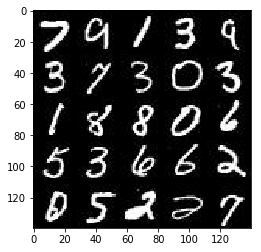

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

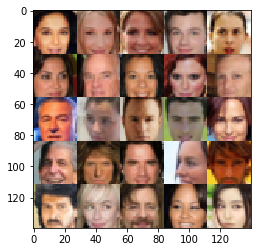

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = "real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator",reuse=reuse):
        alpha=0.2

        l1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        l1 = tf.maximum(l1 * alpha, l1)

        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2,training=True)
        l2 = tf.maximum(l2 * alpha, l2)
        
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l2,training=True)
        l3 = tf.maximum(l3 * alpha, l2)
        
        flat = tf.reshape(l2, (-1,7*7*256))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now

        # 28x28x(out_channel_dimension) now
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        return tf.tanh(logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # get counterfit from generator, 
    # get output from discriminator using real input
    # get output from discriminator using counterfit generated
    g_out = generator(input_z,out_channel_dim=out_channel_dim)
    d_real_out, d_real_logit = discriminator(input_real)
    d_fake_out, d_fake_logit = discriminator(g_out,reuse=True)
    
    # shortcut loss calculation function
    calculate_loss = lambda logits,labels : tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))
    
    d_loss_real = calculate_loss(d_real_logit, tf.ones_like(d_real_out))
    d_loss_fake = calculate_loss(d_fake_logit, tf.zeros_like(d_fake_out))
    
    g_loss = calculate_loss(d_fake_logit, tf.ones_like(d_fake_out))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # get variables for `var_list` minimize parameter
    trainables = tf.trainable_variables()

    # filter those by generator/discriminator
    gen_train = [operation for operation in trainables if operation.name.startswith('generator')]
    dis_train = [operation for operation in trainables if operation.name.startswith('discriminator')]

    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # use with control dependencies for batch normalization calculations updating
    with tf.control_dependencies(g_update_ops):
        # calculate optimizations
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=gen_train)

    # use with control dependencies for batch normalization calculations updating
    with tf.control_dependencies(d_update_ops):
        # calculate optimizations
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=dis_train)
        
    return g_train_opt, d_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_input, z_input, lr = model_inputs(data_shape[1],
                                           data_shape[2], 
                                           data_shape[3], 
                                           z_dim)
    
    d_loss, g_loss = model_loss(real_input, 
                                z_input, 
                                data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss,
                             g_loss,
                             learning_rate,
                             beta1)
    
    steps, step_text_update, step_example_update = 0, 10, 100
    sample_size = 20
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                # resize b/c we used -.5 to .5 instead of -1 to 1
                batch_images = batch_images * 2
                
                # random sample noise 
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr: learning_rate, real_input: batch_images})
                
                if steps % step_text_update == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("epoch {}/{} ***".format(epoch_i+1, epochs),
                          "discriminator loss: {:.4f} ***".format(train_loss_d),
                          "generator loss: {:.4f}".format(train_loss_g))                    
                
                if steps % step_example_update == 0:
                    show_generator_output(sess, sample_size, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch 1/2 *** discriminator loss: 0.1849 *** generator loss: 2.9822
epoch 1/2 *** discriminator loss: 0.0615 *** generator loss: 3.7112
epoch 1/2 *** discriminator loss: 0.2143 *** generator loss: 3.0750
epoch 1/2 *** discriminator loss: 0.2097 *** generator loss: 2.9871
epoch 1/2 *** discriminator loss: 0.7454 *** generator loss: 2.3345
epoch 1/2 *** discriminator loss: 0.3345 *** generator loss: 2.5210
epoch 1/2 *** discriminator loss: 0.7001 *** generator loss: 1.9864
epoch 1/2 *** discriminator loss: 0.7200 *** generator loss: 1.2968
epoch 1/2 *** discriminator loss: 0.8799 *** generator loss: 1.1349
epoch 1/2 *** discriminator loss: 1.0820 *** generator loss: 0.9740


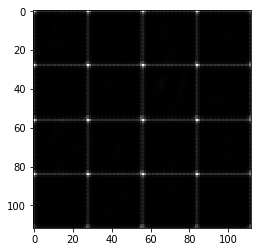

epoch 1/2 *** discriminator loss: 1.2622 *** generator loss: 1.0092
epoch 1/2 *** discriminator loss: 1.3721 *** generator loss: 0.8743
epoch 1/2 *** discriminator loss: 1.5142 *** generator loss: 0.5871
epoch 1/2 *** discriminator loss: 1.3205 *** generator loss: 0.7917
epoch 1/2 *** discriminator loss: 1.2237 *** generator loss: 0.7832
epoch 1/2 *** discriminator loss: 1.2958 *** generator loss: 0.7699
epoch 1/2 *** discriminator loss: 1.1989 *** generator loss: 0.8311
epoch 1/2 *** discriminator loss: 1.1978 *** generator loss: 0.9952
epoch 1/2 *** discriminator loss: 1.1948 *** generator loss: 0.8194
epoch 1/2 *** discriminator loss: 1.2600 *** generator loss: 0.6653


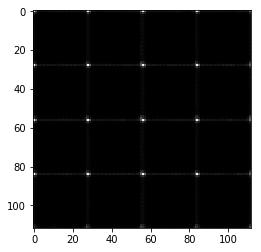

epoch 1/2 *** discriminator loss: 1.1357 *** generator loss: 0.7557
epoch 1/2 *** discriminator loss: 1.2591 *** generator loss: 1.1392
epoch 1/2 *** discriminator loss: 1.2401 *** generator loss: 0.7448
epoch 1/2 *** discriminator loss: 1.2154 *** generator loss: 0.5921
epoch 1/2 *** discriminator loss: 1.1596 *** generator loss: 1.0252
epoch 1/2 *** discriminator loss: 1.1259 *** generator loss: 0.9442
epoch 1/2 *** discriminator loss: 1.1255 *** generator loss: 0.9206
epoch 1/2 *** discriminator loss: 1.1574 *** generator loss: 0.9756
epoch 1/2 *** discriminator loss: 1.0949 *** generator loss: 0.9182
epoch 1/2 *** discriminator loss: 1.1250 *** generator loss: 1.1747


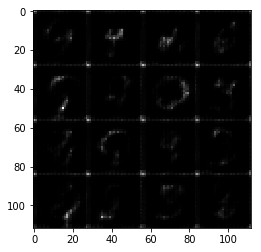

epoch 1/2 *** discriminator loss: 1.1706 *** generator loss: 0.9068
epoch 1/2 *** discriminator loss: 1.1273 *** generator loss: 0.9079
epoch 1/2 *** discriminator loss: 1.2310 *** generator loss: 1.2680
epoch 1/2 *** discriminator loss: 1.0554 *** generator loss: 0.8016
epoch 1/2 *** discriminator loss: 1.2022 *** generator loss: 0.8100
epoch 1/2 *** discriminator loss: 1.1855 *** generator loss: 1.1250
epoch 1/2 *** discriminator loss: 1.1461 *** generator loss: 1.0485
epoch 1/2 *** discriminator loss: 1.1772 *** generator loss: 0.8201
epoch 1/2 *** discriminator loss: 1.1843 *** generator loss: 0.7182
epoch 1/2 *** discriminator loss: 1.2415 *** generator loss: 0.5982


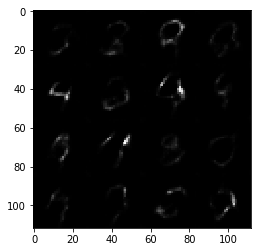

epoch 1/2 *** discriminator loss: 1.1654 *** generator loss: 1.0575
epoch 1/2 *** discriminator loss: 1.2026 *** generator loss: 0.7189
epoch 1/2 *** discriminator loss: 1.1373 *** generator loss: 0.8842
epoch 1/2 *** discriminator loss: 1.2328 *** generator loss: 0.8117
epoch 1/2 *** discriminator loss: 0.9602 *** generator loss: 0.8818
epoch 1/2 *** discriminator loss: 0.9370 *** generator loss: 0.8795
epoch 2/2 *** discriminator loss: 1.0971 *** generator loss: 1.1056
epoch 2/2 *** discriminator loss: 1.2003 *** generator loss: 0.6177
epoch 2/2 *** discriminator loss: 1.1813 *** generator loss: 1.1160
epoch 2/2 *** discriminator loss: 1.1432 *** generator loss: 1.1435


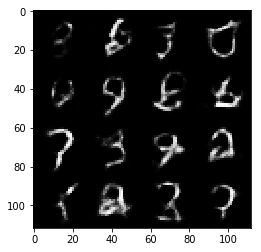

epoch 2/2 *** discriminator loss: 1.1084 *** generator loss: 0.8247
epoch 2/2 *** discriminator loss: 1.2680 *** generator loss: 0.6925
epoch 2/2 *** discriminator loss: 1.2671 *** generator loss: 0.8233
epoch 2/2 *** discriminator loss: 1.2129 *** generator loss: 0.7514
epoch 2/2 *** discriminator loss: 1.2433 *** generator loss: 0.9586
epoch 2/2 *** discriminator loss: 1.2570 *** generator loss: 0.7146
epoch 2/2 *** discriminator loss: 1.2846 *** generator loss: 0.6073
epoch 2/2 *** discriminator loss: 1.2129 *** generator loss: 0.8951
epoch 2/2 *** discriminator loss: 1.2798 *** generator loss: 0.7203
epoch 2/2 *** discriminator loss: 1.2260 *** generator loss: 0.7935


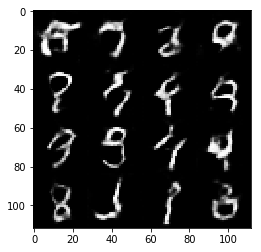

epoch 2/2 *** discriminator loss: 1.2703 *** generator loss: 0.6348
epoch 2/2 *** discriminator loss: 1.2516 *** generator loss: 0.7925
epoch 2/2 *** discriminator loss: 1.2207 *** generator loss: 0.8024
epoch 2/2 *** discriminator loss: 1.2562 *** generator loss: 1.0512
epoch 2/2 *** discriminator loss: 1.2933 *** generator loss: 1.1638
epoch 2/2 *** discriminator loss: 1.2113 *** generator loss: 0.7783
epoch 2/2 *** discriminator loss: 1.2276 *** generator loss: 0.9277
epoch 2/2 *** discriminator loss: 1.2311 *** generator loss: 0.7254
epoch 2/2 *** discriminator loss: 1.2213 *** generator loss: 0.7827
epoch 2/2 *** discriminator loss: 1.2450 *** generator loss: 0.6936


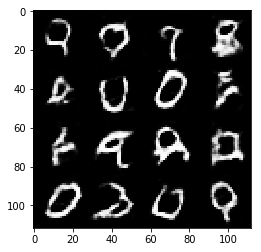

epoch 2/2 *** discriminator loss: 1.2319 *** generator loss: 0.5924
epoch 2/2 *** discriminator loss: 1.2375 *** generator loss: 0.6593
epoch 2/2 *** discriminator loss: 1.1992 *** generator loss: 0.9057
epoch 2/2 *** discriminator loss: 1.2045 *** generator loss: 0.8935
epoch 2/2 *** discriminator loss: 1.2323 *** generator loss: 0.6720
epoch 2/2 *** discriminator loss: 1.2336 *** generator loss: 0.6507
epoch 2/2 *** discriminator loss: 1.2259 *** generator loss: 1.0045
epoch 2/2 *** discriminator loss: 1.3587 *** generator loss: 1.4373
epoch 2/2 *** discriminator loss: 1.1950 *** generator loss: 0.7757
epoch 2/2 *** discriminator loss: 1.2741 *** generator loss: 0.5473


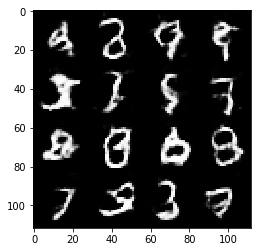

epoch 2/2 *** discriminator loss: 1.2159 *** generator loss: 0.6994
epoch 2/2 *** discriminator loss: 1.2093 *** generator loss: 0.7850
epoch 2/2 *** discriminator loss: 1.2266 *** generator loss: 1.1818
epoch 2/2 *** discriminator loss: 1.1788 *** generator loss: 0.7275
epoch 2/2 *** discriminator loss: 1.1648 *** generator loss: 0.9446
epoch 2/2 *** discriminator loss: 1.4097 *** generator loss: 0.4004
epoch 2/2 *** discriminator loss: 1.1009 *** generator loss: 0.9806
epoch 2/2 *** discriminator loss: 1.1531 *** generator loss: 0.8928
epoch 2/2 *** discriminator loss: 1.1964 *** generator loss: 0.7013
epoch 2/2 *** discriminator loss: 1.1681 *** generator loss: 0.8772


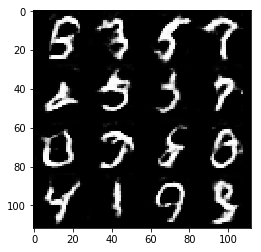

epoch 2/2 *** discriminator loss: 1.2146 *** generator loss: 0.7300
epoch 2/2 *** discriminator loss: 1.1852 *** generator loss: 0.9893
epoch 2/2 *** discriminator loss: 1.1806 *** generator loss: 0.7096


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch 1/1 *** discriminator loss: 0.7758 *** generator loss: 1.7611
epoch 1/1 *** discriminator loss: 0.4189 *** generator loss: 2.5628
epoch 1/1 *** discriminator loss: 0.4177 *** generator loss: 2.8123
epoch 1/1 *** discriminator loss: 0.4187 *** generator loss: 2.7117
epoch 1/1 *** discriminator loss: 0.4134 *** generator loss: 2.9076
epoch 1/1 *** discriminator loss: 0.2968 *** generator loss: 2.9042
epoch 1/1 *** discriminator loss: 0.7525 *** generator loss: 2.9332
epoch 1/1 *** discriminator loss: 0.6160 *** generator loss: 2.1627
epoch 1/1 *** discriminator loss: 0.6852 *** generator loss: 1.4699
epoch 1/1 *** discriminator loss: 0.4671 *** generator loss: 2.4923


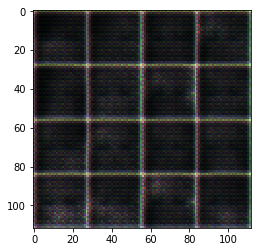

epoch 1/1 *** discriminator loss: 0.6078 *** generator loss: 2.0564
epoch 1/1 *** discriminator loss: 0.5154 *** generator loss: 2.0983
epoch 1/1 *** discriminator loss: 0.4534 *** generator loss: 1.7167
epoch 1/1 *** discriminator loss: 0.9003 *** generator loss: 2.8935
epoch 1/1 *** discriminator loss: 0.3820 *** generator loss: 2.4757
epoch 1/1 *** discriminator loss: 0.6278 *** generator loss: 2.6522
epoch 1/1 *** discriminator loss: 0.4176 *** generator loss: 2.0062
epoch 1/1 *** discriminator loss: 0.4756 *** generator loss: 2.4359
epoch 1/1 *** discriminator loss: 0.4385 *** generator loss: 2.1286
epoch 1/1 *** discriminator loss: 0.3634 *** generator loss: 1.8773


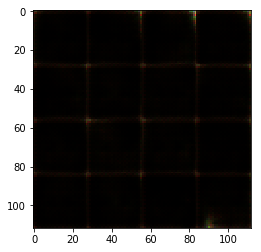

epoch 1/1 *** discriminator loss: 0.2760 *** generator loss: 2.5116
epoch 1/1 *** discriminator loss: 0.7868 *** generator loss: 2.1962
epoch 1/1 *** discriminator loss: 0.2439 *** generator loss: 3.5934
epoch 1/1 *** discriminator loss: 0.1639 *** generator loss: 3.1869
epoch 1/1 *** discriminator loss: 0.2886 *** generator loss: 3.4407
epoch 1/1 *** discriminator loss: 0.6447 *** generator loss: 2.0154
epoch 1/1 *** discriminator loss: 0.1711 *** generator loss: 2.7422
epoch 1/1 *** discriminator loss: 0.1188 *** generator loss: 3.5401
epoch 1/1 *** discriminator loss: 0.4045 *** generator loss: 1.5492
epoch 1/1 *** discriminator loss: 0.9380 *** generator loss: 2.2290


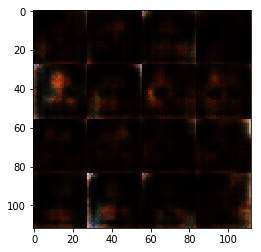

epoch 1/1 *** discriminator loss: 0.2125 *** generator loss: 4.3465
epoch 1/1 *** discriminator loss: 0.9596 *** generator loss: 1.9679
epoch 1/1 *** discriminator loss: 0.2611 *** generator loss: 2.3504
epoch 1/1 *** discriminator loss: 0.3196 *** generator loss: 2.1992
epoch 1/1 *** discriminator loss: 0.3202 *** generator loss: 3.0950
epoch 1/1 *** discriminator loss: 1.0850 *** generator loss: 1.7100
epoch 1/1 *** discriminator loss: 0.7998 *** generator loss: 1.5258
epoch 1/1 *** discriminator loss: 0.9869 *** generator loss: 1.0561
epoch 1/1 *** discriminator loss: 0.9955 *** generator loss: 1.0470
epoch 1/1 *** discriminator loss: 0.7185 *** generator loss: 1.4522


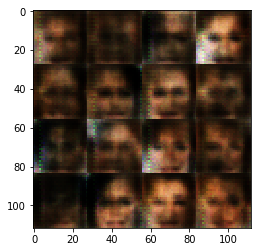

epoch 1/1 *** discriminator loss: 0.9417 *** generator loss: 1.1547
epoch 1/1 *** discriminator loss: 1.0254 *** generator loss: 1.3140
epoch 1/1 *** discriminator loss: 1.0345 *** generator loss: 1.6457
epoch 1/1 *** discriminator loss: 1.0237 *** generator loss: 1.6168
epoch 1/1 *** discriminator loss: 1.0958 *** generator loss: 1.3515
epoch 1/1 *** discriminator loss: 0.8103 *** generator loss: 1.3504
epoch 1/1 *** discriminator loss: 0.8482 *** generator loss: 1.0517
epoch 1/1 *** discriminator loss: 0.9402 *** generator loss: 1.4359
epoch 1/1 *** discriminator loss: 0.7199 *** generator loss: 1.3582
epoch 1/1 *** discriminator loss: 0.5563 *** generator loss: 1.6572


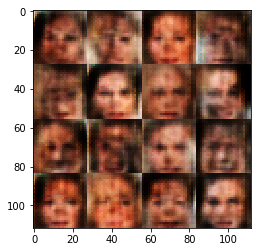

epoch 1/1 *** discriminator loss: 0.7985 *** generator loss: 1.5396
epoch 1/1 *** discriminator loss: 0.9341 *** generator loss: 1.0029
epoch 1/1 *** discriminator loss: 0.7012 *** generator loss: 1.4420
epoch 1/1 *** discriminator loss: 0.5967 *** generator loss: 1.9055
epoch 1/1 *** discriminator loss: 0.6924 *** generator loss: 1.8164
epoch 1/1 *** discriminator loss: 0.5118 *** generator loss: 1.5437
epoch 1/1 *** discriminator loss: 0.5823 *** generator loss: 1.7003
epoch 1/1 *** discriminator loss: 0.5843 *** generator loss: 1.9376
epoch 1/1 *** discriminator loss: 0.5636 *** generator loss: 1.4398
epoch 1/1 *** discriminator loss: 0.7080 *** generator loss: 1.8097


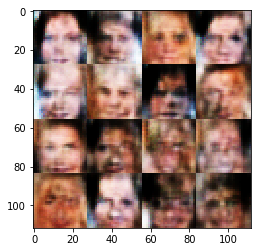

epoch 1/1 *** discriminator loss: 0.7463 *** generator loss: 1.6150
epoch 1/1 *** discriminator loss: 0.8100 *** generator loss: 1.5471
epoch 1/1 *** discriminator loss: 0.5099 *** generator loss: 1.8370
epoch 1/1 *** discriminator loss: 0.9631 *** generator loss: 2.0801
epoch 1/1 *** discriminator loss: 0.5784 *** generator loss: 1.6153
epoch 1/1 *** discriminator loss: 0.9537 *** generator loss: 1.1154
epoch 1/1 *** discriminator loss: 0.5089 *** generator loss: 1.8256
epoch 1/1 *** discriminator loss: 1.1712 *** generator loss: 1.4069
epoch 1/1 *** discriminator loss: 0.5118 *** generator loss: 1.8739
epoch 1/1 *** discriminator loss: 0.8644 *** generator loss: 1.2338


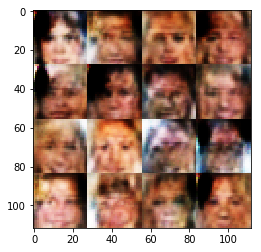

epoch 1/1 *** discriminator loss: 0.5193 *** generator loss: 1.6442
epoch 1/1 *** discriminator loss: 0.6023 *** generator loss: 1.5812
epoch 1/1 *** discriminator loss: 1.3695 *** generator loss: 2.5509
epoch 1/1 *** discriminator loss: 0.4916 *** generator loss: 1.6506
epoch 1/1 *** discriminator loss: 0.6700 *** generator loss: 1.8330
epoch 1/1 *** discriminator loss: 0.9094 *** generator loss: 1.8846
epoch 1/1 *** discriminator loss: 0.6344 *** generator loss: 1.5215
epoch 1/1 *** discriminator loss: 0.5972 *** generator loss: 1.6092
epoch 1/1 *** discriminator loss: 0.7917 *** generator loss: 1.8012
epoch 1/1 *** discriminator loss: 0.9023 *** generator loss: 1.7571


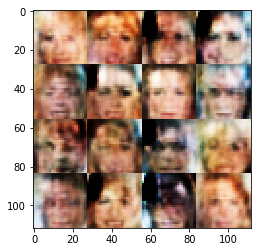

epoch 1/1 *** discriminator loss: 0.7851 *** generator loss: 1.4345
epoch 1/1 *** discriminator loss: 0.5913 *** generator loss: 1.5932
epoch 1/1 *** discriminator loss: 0.5128 *** generator loss: 1.8680
epoch 1/1 *** discriminator loss: 0.8317 *** generator loss: 1.1172
epoch 1/1 *** discriminator loss: 0.5919 *** generator loss: 1.6252
epoch 1/1 *** discriminator loss: 0.8179 *** generator loss: 1.0632
epoch 1/1 *** discriminator loss: 0.7046 *** generator loss: 1.7403
epoch 1/1 *** discriminator loss: 0.6018 *** generator loss: 1.6012
epoch 1/1 *** discriminator loss: 0.7889 *** generator loss: 1.2443
epoch 1/1 *** discriminator loss: 0.7814 *** generator loss: 1.3203


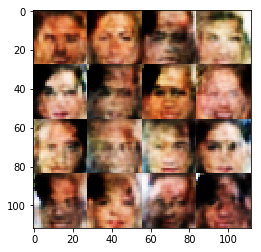

epoch 1/1 *** discriminator loss: 0.6669 *** generator loss: 1.6833
epoch 1/1 *** discriminator loss: 0.4755 *** generator loss: 1.9737
epoch 1/1 *** discriminator loss: 0.9152 *** generator loss: 1.1754
epoch 1/1 *** discriminator loss: 0.6495 *** generator loss: 2.1249
epoch 1/1 *** discriminator loss: 0.6678 *** generator loss: 1.9742
epoch 1/1 *** discriminator loss: 0.5194 *** generator loss: 1.7169
epoch 1/1 *** discriminator loss: 0.7814 *** generator loss: 1.7968
epoch 1/1 *** discriminator loss: 0.6765 *** generator loss: 2.0116
epoch 1/1 *** discriminator loss: 0.6672 *** generator loss: 1.7907
epoch 1/1 *** discriminator loss: 0.7870 *** generator loss: 1.2945


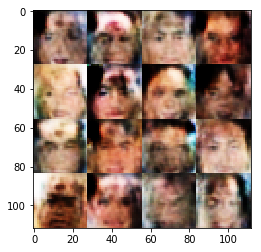

epoch 1/1 *** discriminator loss: 0.6157 *** generator loss: 1.4839
epoch 1/1 *** discriminator loss: 0.9514 *** generator loss: 1.7921
epoch 1/1 *** discriminator loss: 0.7403 *** generator loss: 1.6530
epoch 1/1 *** discriminator loss: 0.7924 *** generator loss: 1.6350
epoch 1/1 *** discriminator loss: 0.9694 *** generator loss: 1.1454
epoch 1/1 *** discriminator loss: 0.9125 *** generator loss: 1.9159
epoch 1/1 *** discriminator loss: 0.8478 *** generator loss: 1.4878
epoch 1/1 *** discriminator loss: 1.2057 *** generator loss: 2.2518
epoch 1/1 *** discriminator loss: 0.7512 *** generator loss: 1.2807
epoch 1/1 *** discriminator loss: 0.7461 *** generator loss: 1.5465


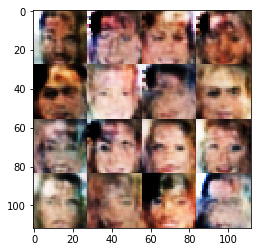

epoch 1/1 *** discriminator loss: 0.5598 *** generator loss: 2.1965
epoch 1/1 *** discriminator loss: 0.6928 *** generator loss: 1.6759
epoch 1/1 *** discriminator loss: 0.7346 *** generator loss: 1.2924
epoch 1/1 *** discriminator loss: 0.8612 *** generator loss: 1.5621
epoch 1/1 *** discriminator loss: 0.7398 *** generator loss: 1.9848
epoch 1/1 *** discriminator loss: 0.7975 *** generator loss: 1.7448
epoch 1/1 *** discriminator loss: 0.8598 *** generator loss: 1.2909
epoch 1/1 *** discriminator loss: 0.8065 *** generator loss: 1.4685
epoch 1/1 *** discriminator loss: 0.9999 *** generator loss: 1.3012
epoch 1/1 *** discriminator loss: 0.6102 *** generator loss: 1.7226


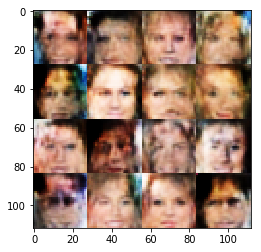

epoch 1/1 *** discriminator loss: 0.7955 *** generator loss: 1.3398
epoch 1/1 *** discriminator loss: 0.8832 *** generator loss: 1.3861
epoch 1/1 *** discriminator loss: 0.7022 *** generator loss: 1.8845
epoch 1/1 *** discriminator loss: 0.8850 *** generator loss: 1.7387
epoch 1/1 *** discriminator loss: 0.8251 *** generator loss: 1.8818
epoch 1/1 *** discriminator loss: 0.6087 *** generator loss: 2.4723
epoch 1/1 *** discriminator loss: 0.8100 *** generator loss: 1.5609
epoch 1/1 *** discriminator loss: 0.8866 *** generator loss: 1.1971
epoch 1/1 *** discriminator loss: 0.7954 *** generator loss: 1.6386
epoch 1/1 *** discriminator loss: 0.6646 *** generator loss: 1.7408


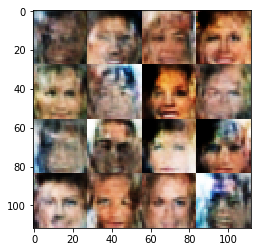

epoch 1/1 *** discriminator loss: 0.9694 *** generator loss: 1.3242
epoch 1/1 *** discriminator loss: 0.9139 *** generator loss: 1.8438
epoch 1/1 *** discriminator loss: 0.5465 *** generator loss: 1.9256
epoch 1/1 *** discriminator loss: 0.7902 *** generator loss: 1.0734
epoch 1/1 *** discriminator loss: 0.6954 *** generator loss: 1.8171
epoch 1/1 *** discriminator loss: 0.7365 *** generator loss: 1.5821
epoch 1/1 *** discriminator loss: 0.8655 *** generator loss: 1.5946
epoch 1/1 *** discriminator loss: 0.8984 *** generator loss: 1.2996
epoch 1/1 *** discriminator loss: 0.7441 *** generator loss: 1.3188
epoch 1/1 *** discriminator loss: 0.7350 *** generator loss: 1.2646


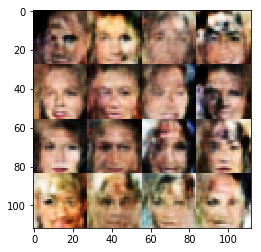

epoch 1/1 *** discriminator loss: 0.7092 *** generator loss: 1.6107
epoch 1/1 *** discriminator loss: 1.0302 *** generator loss: 1.9344
epoch 1/1 *** discriminator loss: 0.8900 *** generator loss: 1.4607
epoch 1/1 *** discriminator loss: 0.8175 *** generator loss: 1.2424
epoch 1/1 *** discriminator loss: 0.8543 *** generator loss: 1.3796
epoch 1/1 *** discriminator loss: 0.7079 *** generator loss: 1.2897
epoch 1/1 *** discriminator loss: 0.9350 *** generator loss: 1.4027
epoch 1/1 *** discriminator loss: 0.5255 *** generator loss: 1.6948
epoch 1/1 *** discriminator loss: 0.8683 *** generator loss: 1.3549
epoch 1/1 *** discriminator loss: 0.8739 *** generator loss: 1.5390


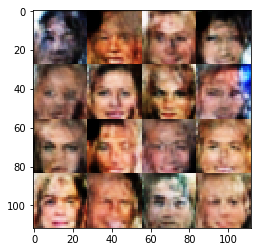

epoch 1/1 *** discriminator loss: 0.7244 *** generator loss: 1.3020
epoch 1/1 *** discriminator loss: 0.9030 *** generator loss: 1.3250
epoch 1/1 *** discriminator loss: 0.9233 *** generator loss: 1.9935
epoch 1/1 *** discriminator loss: 0.6304 *** generator loss: 1.9243
epoch 1/1 *** discriminator loss: 0.9224 *** generator loss: 1.5024
epoch 1/1 *** discriminator loss: 0.8509 *** generator loss: 1.2108
epoch 1/1 *** discriminator loss: 0.9228 *** generator loss: 1.1528
epoch 1/1 *** discriminator loss: 0.8122 *** generator loss: 1.9178


In [15]:
batch_size = 128
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.